In [26]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Load the .arff file
url='C:/Code/intrusion_detection/KDDTest+.arff'
data, meta = arff.loadarff('KDDTest+.arff')

# Convert to DataFrame
df = pd.DataFrame(data)


# # Read .txt file (comma-separated or tab-separated)
# url='C:/Code/intrusion_detection/KDDTrain+.txt'
# df = pd.read_csv(url, delimiter=',',)  # Change delimiter if needed



# Preview the dataset
print(df.head())

   duration protocol_type      service     flag  src_bytes  dst_bytes  land  \
0       0.0        b'tcp'   b'private'   b'REJ'        0.0        0.0  b'0'   
1       0.0        b'tcp'   b'private'   b'REJ'        0.0        0.0  b'0'   
2       2.0        b'tcp'  b'ftp_data'    b'SF'    12983.0        0.0  b'0'   
3       0.0       b'icmp'     b'eco_i'    b'SF'       20.0        0.0  b'0'   
4       1.0        b'tcp'    b'telnet'  b'RSTO'        0.0       15.0  b'0'   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0             0.0     0.0  0.0  ...                10.0   
1             0.0     0.0  0.0  ...                 1.0   
2             0.0     0.0  0.0  ...                86.0   
3             0.0     0.0  0.0  ...                57.0   
4             0.0     0.0  0.0  ...                86.0   

  dst_host_same_srv_rate  dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                   0.04                    0.06                         0.00   
1       

In [28]:
string_columns = df.select_dtypes([object]).columns
df[string_columns] = df[string_columns].apply(lambda x: x.str.decode('utf-8'))

In [29]:
X = df.drop('class', axis=1)
y = df['class']

In [30]:
# Encode categorical variables
categorical_columns = ['protocol_type', 'service', 'flag']
for col in categorical_columns:
    X[col] = LabelEncoder().fit_transform(X[col])

In [31]:
# Convert binary attributes to numeric
binary_columns = ['land', 'logged_in', 'is_host_login', 'is_guest_login']
for col in binary_columns:
    X[col] = X[col].astype(int)

In [32]:
# Ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle any NaN values that might have been introduced
X = X.fillna(X.mean())

In [33]:
# Normalize numeric features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [34]:
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [36]:
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2584
           1       0.95      0.91      0.93      1925

    accuracy                           0.94      4509
   macro avg       0.94      0.94      0.94      4509
weighted avg       0.94      0.94      0.94      4509

Training Accuracy: 0.9474
Testing Accuracy: 0.9434


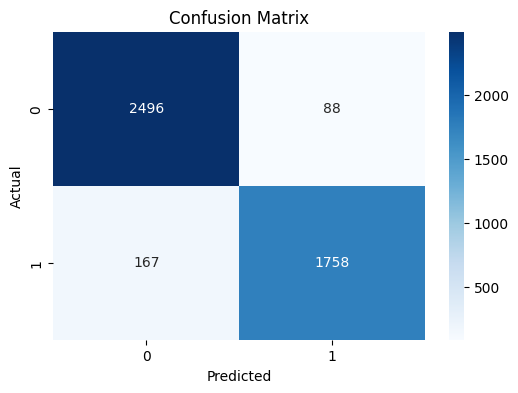

In [37]:
# Evaluate the model
print(classification_report(y_test, y_pred, digits=4))

print(f"Training Accuracy: {model.score(X_train, y_train):.4f}")
print(f"Testing Accuracy: {model.score(X_test, y_test):.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

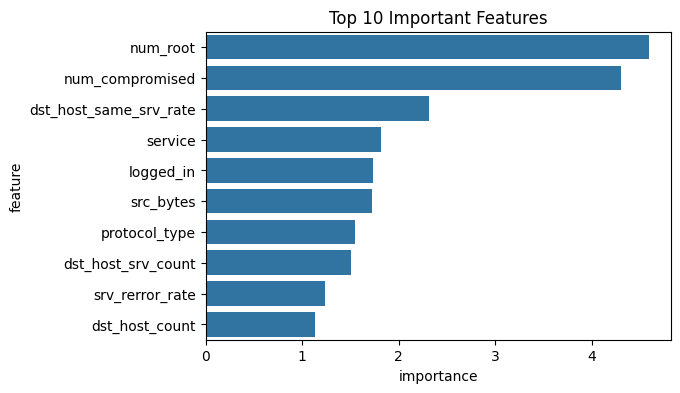

In [38]:
# Feature importance
importance = pd.DataFrame({'feature': X.columns, 'importance': abs(model.coef_[0])})
importance = importance.sort_values('importance', ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x='importance', y='feature', data=importance.head(10))
plt.title('Top 10 Important Features')
plt.show()

In [39]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

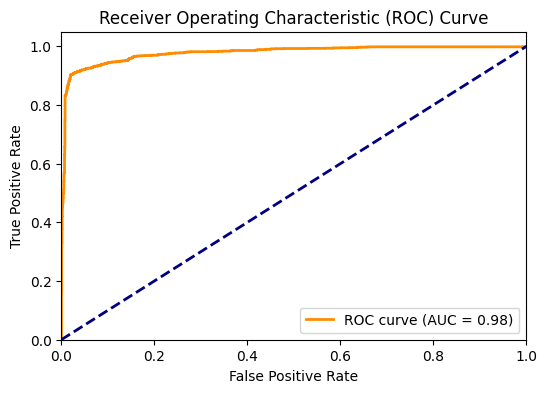

In [40]:
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [41]:
#KNN Model
from sklearn.neighbors import KNeighborsClassifier

In [42]:
# Find the optimal K value
param_grid = {'n_neighbors': np.arange(1, 25)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best K value: {grid_search.best_params_['n_neighbors']}")

Best K value: 1


In [43]:
# Create and train the model with the best K value
best_k = grid_search.best_params_['n_neighbors']
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [44]:
# Make predictions
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

      normal     0.9594    0.9795    0.9694      2584
     anomaly     0.9717    0.9444    0.9579      1925

    accuracy                         0.9645      4509
   macro avg     0.9656    0.9620    0.9636      4509
weighted avg     0.9647    0.9645    0.9644      4509

Training Accuracy: 0.9697
Testing Accuracy: 0.9645


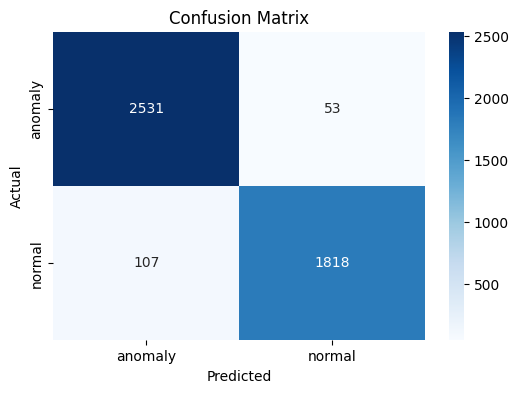

In [45]:
# Evaluate the model
target_names = ['normal', 'anomaly']
print(classification_report(y_test, y_pred, target_names=target_names,digits=4))
print(f"Training Accuracy: {model.score(X_train, y_train):.4f}")
print(f"Testing Accuracy: {model.score(X_test, y_test):.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


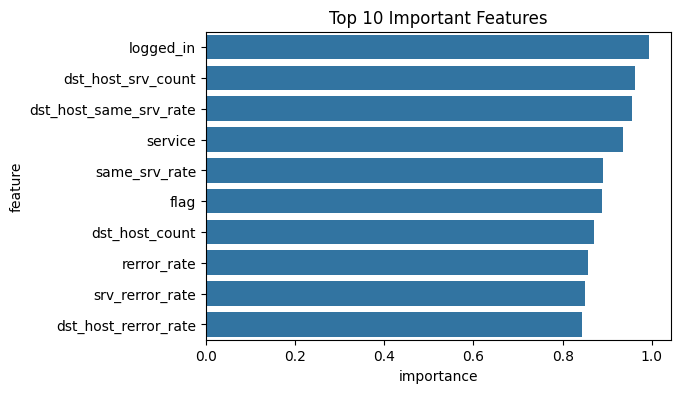

In [46]:
# Feature importance (for KNN, we'll use feature weights based on distance)
feature_importance = np.mean(np.abs(X_train), axis=0)
importance = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
importance = importance.sort_values('importance', ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x='importance', y='feature', data=importance.head(10))
plt.title('Top 10 Important Features')
plt.show()

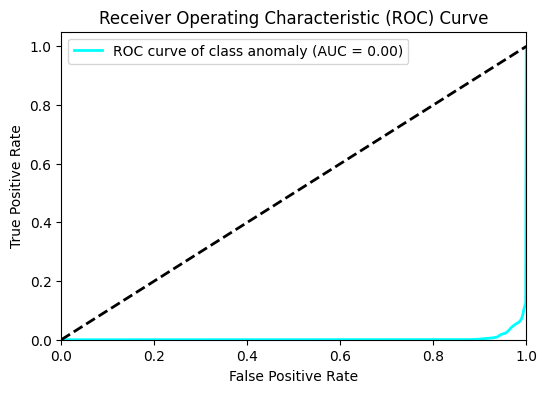

In [47]:
# ROC Curve (for multi-class, we'll use one-vs-rest)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = model.predict_proba(X_test)

n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6,4))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="upper left")
plt.show()

In [48]:
#Naive Bayers
from sklearn.naive_bayes import GaussianNB

In [49]:
nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

GaussianNB()

In [50]:
y_pred = nb_model.predict(X_test)


              precision    recall  f1-score   support

      normal     0.9664    0.7233    0.8274      2584
     anomaly     0.7223    0.9662    0.8267      1925

    accuracy                         0.8270      4509
   macro avg     0.8444    0.8448    0.8270      4509
weighted avg     0.8622    0.8270    0.8271      4509

Training Accuracy: 0.8371
Testing Accuracy: 0.8270


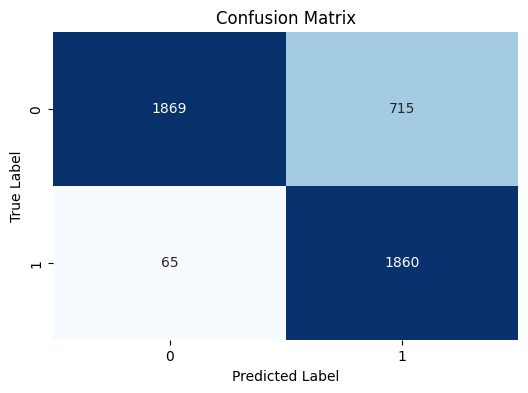

In [52]:
# Evaluate the model
target_names = ['normal', 'anomaly']
print(classification_report(y_test, y_pred, target_names=target_names,digits=4))
print(f"Training Accuracy: {nb_model.score(X_train, y_train):.4f}")
print(f"Testing Accuracy: {nb_model.score(X_test, y_test):.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()